## GOOGLE OR INCEPTION NET ARCHITECTURE

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
import tensorflow as tf
print(tf.__version__)

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2.12.0


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)
train_data=train.flow_from_directory(directory = 'DATASET/TRAIN',target_size=(224,224),
                                     batch_size=32,class_mode='categorical')

Found 9944 images belonging to 5 classes.


In [4]:
test=ImageDataGenerator(rescale=1./255)
test_data=test.flow_from_directory(directory = 'DATASET/TEST',target_size=(224,224),
                                   batch_size=32,class_mode='categorical')

Found 1500 images belonging to 5 classes.


In [5]:
def googlenet(input_shape, n_classes):
  
  def inception_block(x, f):
    t1 = Conv2D(f[0], 1, activation='relu')(x)
    
    t2 = Conv2D(f[1], 1, activation='relu')(x)
    t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)
    
    t3 = Conv2D(f[3], 1, activation='relu')(x)
    t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)
    
    t4 = MaxPool2D(3, 1, padding='same')(x)
    t4 = Conv2D(f[5], 1, activation='relu')(t4)
    
    output = Concatenate()([t1, t2, t3, t4])
    return output
  
  
  input = Input(input_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = Conv2D(64, 1, activation='relu')(x)
  x = Conv2D(192, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = inception_block(x, [64, 96, 128, 16, 32, 32])
  x = inception_block(x, [128, 128, 192, 32, 96, 64])
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = inception_block(x, [192, 96, 208, 16, 48, 64])
  x = inception_block(x, [160, 112, 224, 24, 64, 64])
  x = inception_block(x, [128, 128, 256, 24, 64, 64])
  x = inception_block(x, [112, 144, 288, 32, 64, 64])
  x = inception_block(x, [256, 160, 320, 32, 128, 128])
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = inception_block(x, [256, 160, 320, 32, 128, 128])
  x = inception_block(x, [384, 192, 384, 48, 128, 128])
  
  x = AvgPool2D(7, strides=1)(x)
  x = Dropout(0.4)(x)
  
  x = Flatten()(x)
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',tensorflow.keras.metrics.Precision()])
  return model
     

input_shape = 224, 224, 3
n_classes = 5

K.clear_session()
model = googlenet(input_shape, n_classes)
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [6]:
model_path = "GOOGLE.h5"

from keras.callbacks import ModelCheckpoint

M = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, save_best_only=True)

In [7]:
epochs = 20
batch_size = 512

In [8]:
#### Fitting the model
history = model.fit(
           train_data, steps_per_epoch=train_data.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_data,validation_steps=test_data.samples // batch_size,
           callbacks=[M])

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 1.6130 - accuracy: 0.2056 - precision: 0.0000e+00
Epoch 1: accuracy improved from -inf to 0.20559, saving model to GOOGLE.h5
19/19 [==============================] - 124s 6s/step - loss: 1.6130 - accuracy: 0.2056 - precision: 0.0000e+00 - val_loss: 1.6089 - val_accuracy: 0.2188 - val_precision: 0.0000e+00
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 1.6107 - accuracy: 0.1990 - precision: 0.0000e+00
Epoch 2: accuracy did not improve from 0.20559
19/19 [==============================] - 103s 5s/step - loss: 1.6107 - accuracy: 0.1990 - precision: 0.0000e+00 - val_loss: 1.6091 - val_accuracy: 0.1406 - val_precision: 0.0000e+00
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 1.6102 - accuracy: 0.1990 - precision: 0.0000e+00
Epoch 3: accuracy did not improve from 0.20559
19/19 [==============================] - 104s 5s/step - loss: 1.6102 - accuracy: 0.1990 - precision: 0.0000e+00 -

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])

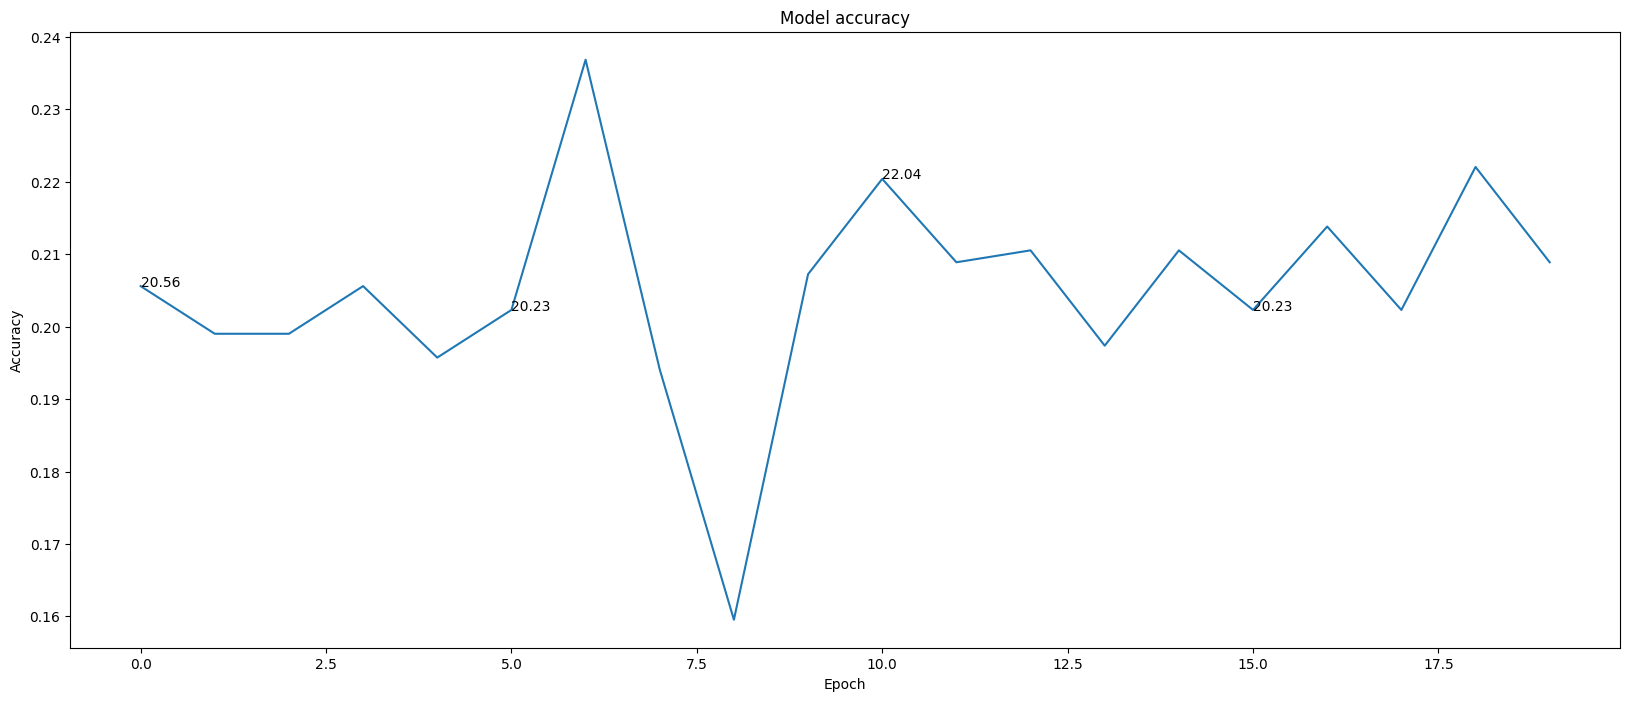

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

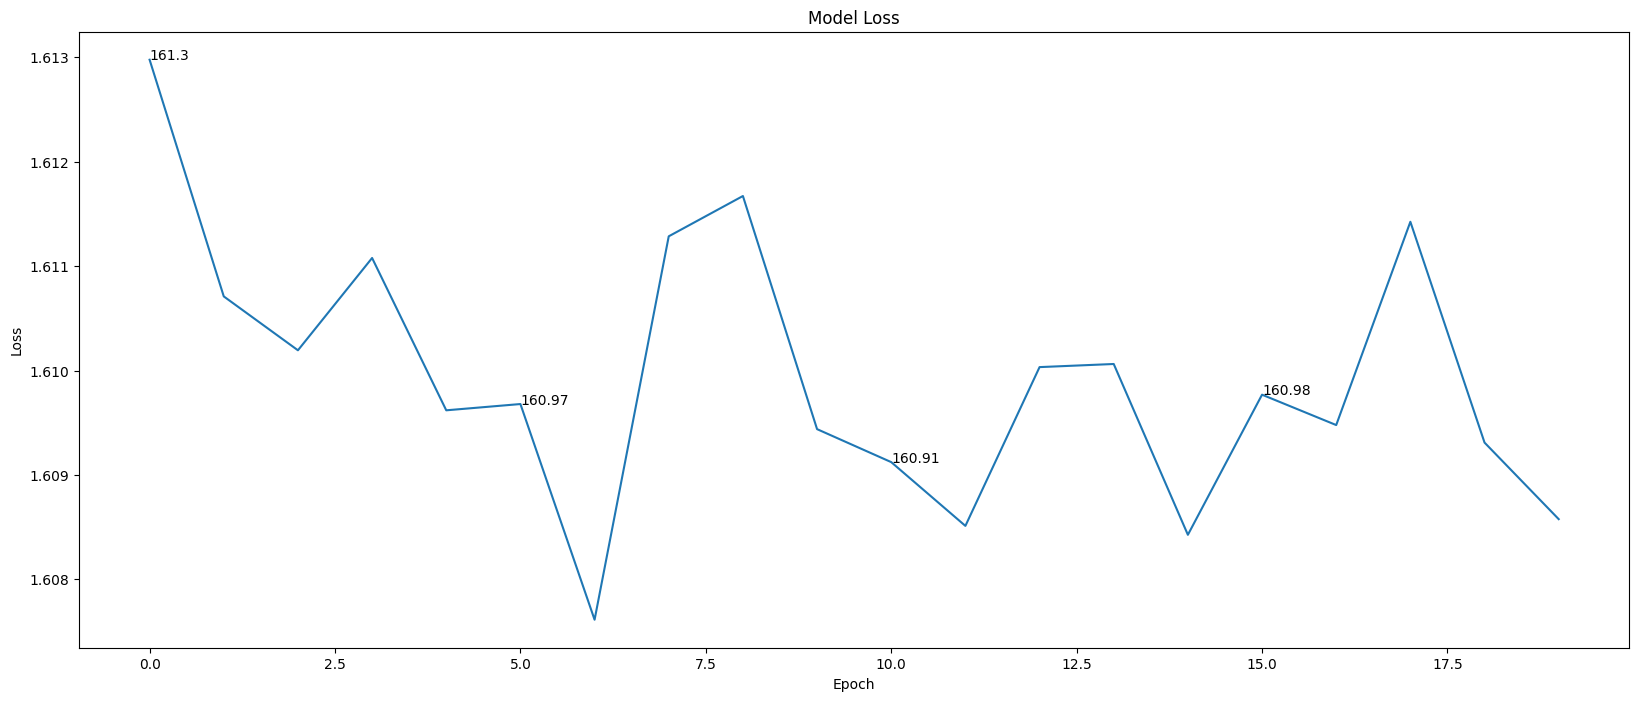

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()